# Evaluate Distribution Learning

In [1]:
%cd ..

/home/adam/Projects/hybrid-transformer


In [2]:
import os
import torch
import wandb

from hybrid_transformer.configs.task import TaskConfig
from hybrid_transformer.configs.model import ModelConfig
from hybrid_transformer.configs.trainer import TrainerConfig
from hybrid_transformer.configs.logger import LoggerConfig

from hybrid_transformer.utils.datasets.auto import AutoDataset
from hybrid_transformer.utils.tokenizers.auto import AutoTokenizer
from hybrid_transformer.models.auto import AutoModel
from hybrid_transformer.utils.loggers.wandb import WandbLogger

from hybrid_transformer.trainers.trainer import Trainer

from scripts.pretrain.train import DEFAULT_CONFIG_FILES

from hybrid_transformer.utils.objectives.guacamol.objective import GUACAMOL_TASKS
from hybrid_transformer.models.prediction import PREDICTION_MODEL_CONFIGS
from hybrid_transformer.models.utils import GuacamolModelWrapper

from hybrid_transformer.utils.objectives.guacamol.objective import get_objective
from hybrid_transformer.utils.objectives.objective import predict_qed

from tqdm import tqdm
from guacamol.utils.chemistry import is_valid

# Auxiliary functions

def save_strings_to_file(strings, filename):
    with open(filename, 'w') as f:
        for s in strings:
            f.write(s + '\n')

def read_strings_from_file(filename):
    with open(filename, 'r') as f:
        strings = f.read().splitlines()
    return strings

def convert_strings_to_lists(strings):
    return [[s, f'MOL{i}'] for i, s in enumerate(strings)]

%load_ext autoreload
%autoreload 2

/home/adam/miniconda3/envs/hybrid-transformer/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-03 16:41:06.807306: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 16:41:06.877173: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 16:41:07.173737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 16:41:07.173775: E external/local_xla/xla/stream_executor/cu

In [3]:
# Load configs

out_dir = f'./results/distribution_learning/'

path_to_task_config = './configs/tasks/guacamol/qed_classification/config.json'
path_to_model_config = './configs/models/hybrid_transformer/config.json'

task_config = TaskConfig.from_pretrained(path_to_task_config)
model_config = ModelConfig.from_pretrained(path_to_model_config)
trainer_config = TrainerConfig.from_pretrained('./configs/trainers/finetune-prediction/config.json')
        
trainer_config.out_dir = out_dir
trainer_config.enable_save_checkpoint = False
trainer_config.batch_size = 64
        
tokenizer = AutoTokenizer.from_config(task_config)                
model = AutoModel.from_config(model_config)
trainer = Trainer(config=trainer_config, model=model, tokenizer=tokenizer)
trainer.load_checkpoint('./results/qed_classification/ckpt.pt')
trainer._train_init()
trainer.model.eval()

number of parameters: 38.06M
tokens per iteration will be: 327,680
Using cuda device
Successfully loaded checkpoint from ./results/qed_classification/ckpt.pt...
Random seed set to 1337
num decayed parameter tensors: 63, with 38,115,840 parameters
num non-decayed parameter tensors: 25, with 12,800 parameters
using fused AdamW: True
Compiling model..


OptimizedModule(
  (_orig_mod): HybridTransformerPreTrained(
    (transformer): ModuleDict(
      (wte): Embedding(588, 512)
      (wpe): Embedding(128, 512)
      (drop): Dropout(p=0.2, inplace=False)
      (h): ModuleList(
        (0-11): 12 x HybridTransformerBlock(
          (ln_1): LayerNorm()
          (attn_1): HybridSelfAttention(
            (q_proj): Linear(in_features=512, out_features=512, bias=False)
            (kv_proj): Linear(in_features=512, out_features=1024, bias=False)
            (out_proj): Linear(in_features=512, out_features=512, bias=False)
            (attn_dropout): Dropout(p=0.2, inplace=False)
            (resid_dropout): Dropout(p=0.2, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (fc): Linear(in_features=512, out_features=2048, bias=False)
            (gelu): GELU(approximate='none')
            (proj): Linear(in_features=2048, out_features=512, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)


In [5]:

temperature = 1.0
top_k = None
number_samples = 64

model_wrapper = GuacamolModelWrapper.init_from_trainer(trainer, temperature=temperature, top_k=top_k)


        

In [6]:
# sample and predict 

samples = model_wrapper.generate(number_samples=number_samples)

KeyboardInterrupt: 

In [7]:
samples = [smiles for smiles in samples if is_valid(smiles)]
samples = [smiles for smiles in samples if smiles is not None]

In [8]:
targets = get_objective(smiles_list=samples, objective='qed')

100%|██████████| 25/25 [00:00<00:00, 935.71it/s]


In [9]:
inputs = trainer.tokenizer._encode(samples, targets, task='mlm', device=trainer.device)

In [10]:
with torch.no_grad():
    output = model(
        task='mlm', input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'],
        labels=inputs['labels'], target=inputs['target'], eos_mask=inputs['eos_mask'])

In [11]:
targets

tensor([[0.4650],
        [0.1457],
        [0.7879],
        [0.8959],
        [0.6797],
        [0.4989],
        [0.8847],
        [0.7273],
        [0.6424],
        [0.8989],
        [0.8508],
        [0.4723],
        [0.3503],
        [0.3318],
        [0.2478],
        [0.3505],
        [0.5499],
        [0.2894],
        [0.3491],
        [0.7500],
        [0.8623],
        [0.6538],
        [0.5772],
        [0.4661],
        [0.6141]])

In [12]:
output['prediction']

tensor([[0.5339],
        [0.2467],
        [0.7268],
        [0.8422],
        [0.7554],
        [0.6946],
        [0.7329],
        [0.6171],
        [0.6386],
        [0.7200],
        [0.8199],
        [0.4177],
        [0.4627],
        [0.3762],
        [0.3382],
        [0.5680],
        [0.5350],
        [0.4195],
        [0.4125],
        [0.7760],
        [0.8484],
        [0.6674],
        [0.7943],
        [0.4867],
        [0.6544]], device='cuda:0')

In [15]:
samples_all = read_strings_from_file('/home/adam/Projects/hybrid-transformer/smiles_generated_qed.txt')
true = get_objective(smiles_list=samples, objective='qed')
predicted = get_objective(smiles_list=samples, objective='qed')

0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [4]:
temperature = 1.0
top_k = None
number_samples = 64

model_wrapper = GuacamolModelWrapper.init_from_trainer(trainer, temperature=temperature, top_k=top_k)


samples = []
qed = []
num_samples_constraint = 0

for idx in tqdm(range(157)):
    batch = model_wrapper.generate(number_samples=number_samples)
    batch = [smiles for smiles in batch if is_valid(smiles)]
    batch = [smiles for smiles in batch if smiles is not None]
    qed_batch = get_objective(smiles_list=batch, objective='qed_classification')
    samples.extend(batch)
    qed.extend(qed_batch)
    num_samples_constraint += len(qed_batch[qed_batch > 0.9])
    print("Current QED: ", max(qed), "Number of samples with QED > 0.9: ", num_samples_constraint)

  1%|          | 1/157 [01:06<2:51:42, 66.04s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  1



  1%|▏         | 2/157 [02:12<2:51:37, 66.44s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  2



  2%|▏         | 3/157 [03:19<2:51:20, 66.76s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  6



  3%|▎         | 4/157 [04:27<2:51:14, 67.15s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  7



  3%|▎         | 5/157 [05:34<2:49:53, 67.06s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  8



  4%|▍         | 6/157 [06:41<2:48:37, 67.00s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  11



  4%|▍         | 7/157 [07:48<2:47:13, 66.89s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  13



  5%|▌         | 8/157 [08:54<2:45:58, 66.83s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  14



  6%|▌         | 9/157 [10:01<2:44:26, 66.67s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  15



  6%|▋         | 10/157 [11:07<2:43:01, 66.54s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  18



  7%|▋         | 11/157 [12:13<2:41:49, 66.50s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  18



  8%|▊         | 12/157 [13:20<2:40:34, 66.45s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  20



  8%|▊         | 13/157 [14:26<2:39:45, 66.56s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  24



  9%|▉         | 14/157 [15:32<2:38:17, 66.41s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  25



 10%|▉         | 15/157 [16:39<2:36:59, 66.33s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  28



 10%|█         | 16/157 [17:46<2:36:15, 66.50s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  30



 11%|█         | 17/157 [18:52<2:35:22, 66.59s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  30



 11%|█▏        | 18/157 [19:59<2:34:24, 66.65s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  31



 12%|█▏        | 19/157 [21:06<2:33:21, 66.68s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  32



 13%|█▎        | 20/157 [22:12<2:32:06, 66.62s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  32



 13%|█▎        | 21/157 [23:19<2:30:57, 66.60s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  32



 14%|█▍        | 22/157 [24:25<2:29:47, 66.57s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  32



 15%|█▍        | 23/157 [25:31<2:28:12, 66.36s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  32



 15%|█▌        | 24/157 [26:38<2:27:07, 66.37s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  32



 16%|█▌        | 25/157 [27:44<2:26:00, 66.37s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  32



 17%|█▋        | 26/157 [28:51<2:25:05, 66.45s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  32



 17%|█▋        | 27/157 [29:58<2:24:14, 66.57s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  34



 18%|█▊        | 28/157 [31:04<2:23:15, 66.63s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  36



 18%|█▊        | 29/157 [32:11<2:22:21, 66.73s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  38



 19%|█▉        | 30/157 [33:19<2:21:49, 67.01s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  39



 20%|█▉        | 31/157 [34:26<2:20:39, 66.98s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  40



 20%|██        | 32/157 [35:32<2:19:11, 66.81s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  42



 21%|██        | 33/157 [36:39<2:17:58, 66.76s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  45



 22%|██▏       | 34/157 [37:46<2:16:50, 66.76s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  46



 22%|██▏       | 35/157 [38:52<2:15:42, 66.74s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  50



 23%|██▎       | 36/157 [39:59<2:14:18, 66.60s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  50



 24%|██▎       | 37/157 [41:05<2:13:09, 66.58s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  50



 24%|██▍       | 38/157 [42:12<2:11:59, 66.55s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  51



 25%|██▍       | 39/157 [43:18<2:10:46, 66.50s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  53



 25%|██▌       | 40/157 [44:24<2:09:39, 66.49s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  54



 26%|██▌       | 41/157 [45:31<2:08:29, 66.46s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  54



 27%|██▋       | 42/157 [46:37<2:07:15, 66.40s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  54



 27%|██▋       | 43/157 [47:44<2:06:29, 66.57s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  55



 28%|██▊       | 44/157 [48:51<2:05:37, 66.71s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  59



 29%|██▊       | 45/157 [49:58<2:04:39, 66.78s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  61



 29%|██▉       | 46/157 [51:05<2:03:38, 66.83s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  62



 30%|██▉       | 47/157 [52:12<2:02:29, 66.81s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  62



 31%|███       | 48/157 [53:19<2:01:37, 66.95s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  65



 31%|███       | 49/157 [54:26<2:00:32, 66.96s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  65



 32%|███▏      | 50/157 [55:33<1:59:18, 66.90s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  67



 32%|███▏      | 51/157 [56:40<1:58:19, 66.98s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  69



 33%|███▎      | 52/157 [57:47<1:57:07, 66.93s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  69



 34%|███▍      | 53/157 [58:54<1:56:03, 66.95s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  71



 34%|███▍      | 54/157 [1:00:00<1:54:38, 66.78s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  73



 35%|███▌      | 55/157 [1:01:07<1:53:36, 66.83s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  75



 36%|███▌      | 56/157 [1:02:14<1:52:20, 66.73s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  76



 36%|███▋      | 57/157 [1:03:20<1:51:06, 66.67s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  78



 37%|███▋      | 58/157 [1:04:27<1:50:03, 66.71s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  79



 38%|███▊      | 59/157 [1:05:33<1:48:49, 66.63s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  80



 38%|███▊      | 60/157 [1:06:40<1:47:47, 66.67s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  81



 39%|███▉      | 61/157 [1:07:46<1:46:29, 66.56s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  83



 39%|███▉      | 62/157 [1:08:53<1:45:21, 66.54s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  83



 40%|████      | 63/157 [1:09:59<1:44:13, 66.53s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  83



 41%|████      | 64/157 [1:11:06<1:43:19, 66.66s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  84



 41%|████▏     | 65/157 [1:12:14<1:42:25, 66.80s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  87



 42%|████▏     | 66/157 [1:13:20<1:41:21, 66.83s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  87



 43%|████▎     | 67/157 [1:14:28<1:40:26, 66.97s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  92



 43%|████▎     | 68/157 [1:15:35<1:39:21, 66.98s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  93



 44%|████▍     | 69/157 [1:16:42<1:38:17, 67.02s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  94



 45%|████▍     | 70/157 [1:17:49<1:37:04, 66.95s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  94



 45%|████▌     | 71/157 [1:18:55<1:35:53, 66.90s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  95



 46%|████▌     | 72/157 [1:20:03<1:34:53, 66.98s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  96



 46%|████▋     | 73/157 [1:21:09<1:33:42, 66.93s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  97



 47%|████▋     | 74/157 [1:22:16<1:32:33, 66.91s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  97



 48%|████▊     | 75/157 [1:23:23<1:31:21, 66.85s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  97



 48%|████▊     | 76/157 [1:24:30<1:30:15, 66.86s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  100



 49%|████▉     | 77/157 [1:25:36<1:28:56, 66.71s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  103



 50%|████▉     | 78/157 [1:26:43<1:27:54, 66.77s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  104



 50%|█████     | 79/157 [1:27:50<1:26:46, 66.76s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  106



 51%|█████     | 80/157 [1:28:56<1:25:37, 66.72s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  106



 52%|█████▏    | 81/157 [1:30:03<1:24:29, 66.71s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  106



 52%|█████▏    | 82/157 [1:31:10<1:23:18, 66.64s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  108



 53%|█████▎    | 83/157 [1:32:17<1:22:16, 66.71s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  110



 54%|█████▎    | 84/157 [1:33:24<1:21:19, 66.85s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  111



 54%|█████▍    | 85/157 [1:34:31<1:20:26, 67.03s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  113



 55%|█████▍    | 86/157 [1:35:39<1:19:33, 67.23s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  113



 55%|█████▌    | 87/157 [1:36:46<1:18:27, 67.25s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  114



 56%|█████▌    | 88/157 [1:37:53<1:17:11, 67.12s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  117



 57%|█████▋    | 89/157 [1:39:00<1:16:02, 67.10s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  118



 57%|█████▋    | 90/157 [1:40:07<1:14:52, 67.05s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  119



 58%|█████▊    | 91/157 [1:41:14<1:13:39, 66.97s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  121



 59%|█████▊    | 92/157 [1:42:20<1:12:11, 66.64s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  124



 59%|█████▉    | 93/157 [1:43:26<1:10:51, 66.43s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  124



 60%|█████▉    | 94/157 [1:44:31<1:09:33, 66.25s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  125



 61%|██████    | 95/157 [1:45:37<1:08:21, 66.15s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  128



 61%|██████    | 96/157 [1:46:43<1:07:08, 66.04s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  130



 62%|██████▏   | 97/157 [1:47:49<1:05:59, 65.99s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  131



 62%|██████▏   | 98/157 [1:48:55<1:04:49, 65.93s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  134



 63%|██████▎   | 99/157 [1:50:01<1:03:49, 66.03s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  136



 64%|██████▎   | 100/157 [1:51:07<1:02:45, 66.05s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  136



 64%|██████▍   | 101/157 [1:52:13<1:01:40, 66.09s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  136



 65%|██████▍   | 102/157 [1:53:19<1:00:33, 66.06s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  138



 66%|██████▌   | 103/157 [1:54:25<59:27, 66.06s/it]  

Current QED:  tensor([1]) Number of samples with QED > 0.9:  139



 66%|██████▌   | 104/157 [1:55:31<58:22, 66.08s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  140



 67%|██████▋   | 105/157 [1:56:37<57:10, 65.98s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  140



 68%|██████▊   | 106/157 [1:57:43<56:02, 65.92s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  143



 68%|██████▊   | 107/157 [1:58:49<54:54, 65.89s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  143



 69%|██████▉   | 108/157 [1:59:55<53:47, 65.86s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  144



 69%|██████▉   | 109/157 [2:01:00<52:41, 65.86s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  144



 70%|███████   | 110/157 [2:02:06<51:34, 65.84s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  146



 71%|███████   | 111/157 [2:03:12<50:28, 65.83s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  149



 71%|███████▏  | 112/157 [2:04:18<49:28, 65.97s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  150



 72%|███████▏  | 113/157 [2:05:25<48:24, 66.02s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  150



 73%|███████▎  | 114/157 [2:06:31<47:20, 66.05s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  153



 73%|███████▎  | 115/157 [2:07:37<46:15, 66.08s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  154



 74%|███████▍  | 116/157 [2:08:43<45:10, 66.10s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  159



 75%|███████▍  | 117/157 [2:09:49<44:05, 66.15s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  160



 75%|███████▌  | 118/157 [2:10:55<42:56, 66.07s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  160



 76%|███████▌  | 119/157 [2:12:01<41:48, 66.01s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  161



 76%|███████▋  | 120/157 [2:13:07<40:41, 65.99s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  162



 77%|███████▋  | 121/157 [2:14:13<39:35, 65.97s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  163



 78%|███████▊  | 122/157 [2:15:19<38:27, 65.92s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  166



 78%|███████▊  | 123/157 [2:16:24<37:19, 65.88s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  167



 79%|███████▉  | 124/157 [2:17:30<36:13, 65.87s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  170



 80%|███████▉  | 125/157 [2:18:36<35:08, 65.88s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  170



 80%|████████  | 126/157 [2:19:42<34:01, 65.87s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  175



 81%|████████  | 127/157 [2:20:48<32:55, 65.87s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  177



 82%|████████▏ | 128/157 [2:21:54<31:48, 65.82s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  177



 82%|████████▏ | 129/157 [2:22:59<30:42, 65.82s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  179



 83%|████████▎ | 130/157 [2:24:05<29:36, 65.79s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  182



 83%|████████▎ | 131/157 [2:25:11<28:30, 65.81s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  183



 84%|████████▍ | 132/157 [2:26:17<27:25, 65.81s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  183



 85%|████████▍ | 133/157 [2:27:23<26:19, 65.80s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  184



 85%|████████▌ | 134/157 [2:28:28<25:13, 65.79s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  184



 86%|████████▌ | 135/157 [2:29:34<24:07, 65.81s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  185



 87%|████████▋ | 136/157 [2:30:40<23:02, 65.82s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  185



 87%|████████▋ | 137/157 [2:31:46<21:56, 65.84s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  187



 88%|████████▊ | 138/157 [2:32:52<20:50, 65.82s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  189



 89%|████████▊ | 139/157 [2:33:57<19:44, 65.82s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  189



 89%|████████▉ | 140/157 [2:35:03<18:39, 65.85s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  190



 90%|████████▉ | 141/157 [2:36:09<17:33, 65.85s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  191



 90%|█████████ | 142/157 [2:37:15<16:27, 65.85s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  192



 91%|█████████ | 143/157 [2:38:21<15:21, 65.83s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  194



 92%|█████████▏| 144/157 [2:39:27<14:15, 65.83s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  197



 92%|█████████▏| 145/157 [2:40:32<13:09, 65.82s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  199



 93%|█████████▎| 146/157 [2:41:38<12:04, 65.85s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  201



 94%|█████████▎| 147/157 [2:42:45<10:59, 65.97s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  202



 94%|█████████▍| 148/157 [2:43:51<09:54, 66.07s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  203



 95%|█████████▍| 149/157 [2:44:58<08:49, 66.21s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  204



 96%|█████████▌| 150/157 [2:46:04<07:44, 66.34s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  209



 96%|█████████▌| 151/157 [2:47:11<06:38, 66.40s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  211



 97%|█████████▋| 152/157 [2:48:18<05:32, 66.56s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  214



 97%|█████████▋| 153/157 [2:49:25<04:26, 66.66s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  216



 98%|█████████▊| 154/157 [2:50:31<03:20, 66.70s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  218



 99%|█████████▊| 155/157 [2:51:39<02:13, 66.87s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  218



 99%|█████████▉| 156/157 [2:52:46<01:07, 67.02s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  219



100%|██████████| 157/157 [2:53:53<00:00, 66.45s/it]

Current QED:  tensor([1]) Number of samples with QED > 0.9:  219


In [5]:
save_strings_to_file(samples, 'smiles_generated_qed_classification_10000.txt')

In [63]:
qed_all = torch.stack(qed).flatten().tolist()

In [66]:
qed_ok = [q for q in qed_all if q >= 0.9]

In [72]:
len(qed_ok)

22

# Load and compare QED distribution for ZINC and Guacamol benchmarks

In [7]:
# Auxiliary functions

def save_strings_to_file(strings, filename):
    with open(filename, 'w') as f:
        for s in strings:
            f.write(s + '\n')

def read_strings_from_file(filename):
    with open(filename, 'r') as f:
        strings = f.read().splitlines()
    return strings

def convert_strings_to_lists(strings):
    return [[s, f'MOL{i}'] for i, s in enumerate(strings)]

In [5]:
samples = read_strings_from_file('./data/guacamol/train/smiles.txt')
valid_samples = [smiles for smiles in samples]
valid_samples = [smiles for smiles in valid_samples if smiles is not None]


In [6]:
qed_samples = get_objective(smiles_list=valid_samples, objective='qed')

In [35]:
qed_samples.flatten().tolist()

[0.504931628704071,
 0.5225687026977539,
 0.6385663747787476,
 0.7774520516395569,
 0.26446670293807983,
 0.39544248580932617,
 0.5132005214691162,
 0.46298643946647644,
 0.7419030666351318,
 0.3476903438568115,
 0.29294589161872864,
 0.6888816952705383,
 0.13480506837368011,
 0.3941485285758972,
 0.6475289463996887,
 0.7810707092285156,
 0.458064466714859,
 0.21059031784534454,
 0.6852680444717407,
 0.8297011256217957,
 0.4229365587234497,
 0.7994977235794067,
 0.22316263616085052,
 0.648066520690918,
 0.7025459408760071,
 0.40815067291259766,
 0.2387177050113678,
 0.5505291223526001,
 0.7024180293083191,
 0.4131746292114258,
 0.6601209044456482,
 0.4818538427352905,
 0.08455295115709305,
 0.6571667194366455,
 0.33042633533477783,
 0.7747039198875427,
 0.6812251806259155,
 0.7346448302268982,
 0.8394709229469299,
 0.7119427919387817,
 0.6386240720748901,
 0.4947114586830139,
 0.3949064612388611,
 0.6240538358688354,
 0.605696439743042,
 0.6018890738487244,
 0.8420906662940979,
 0.4985

In [28]:
qed_samples_ok = qed_samples[qed_samples > 0.9]
len(qed_samples_ok) / len(qed_samples) * 100

2.4706123458197914e-09

In [18]:
import pandas as pd

res = pd.DataFrame({
    'original_qed': qed_samples.flatten(),
    'gen_qed': qed_samples.flatten(),
})

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

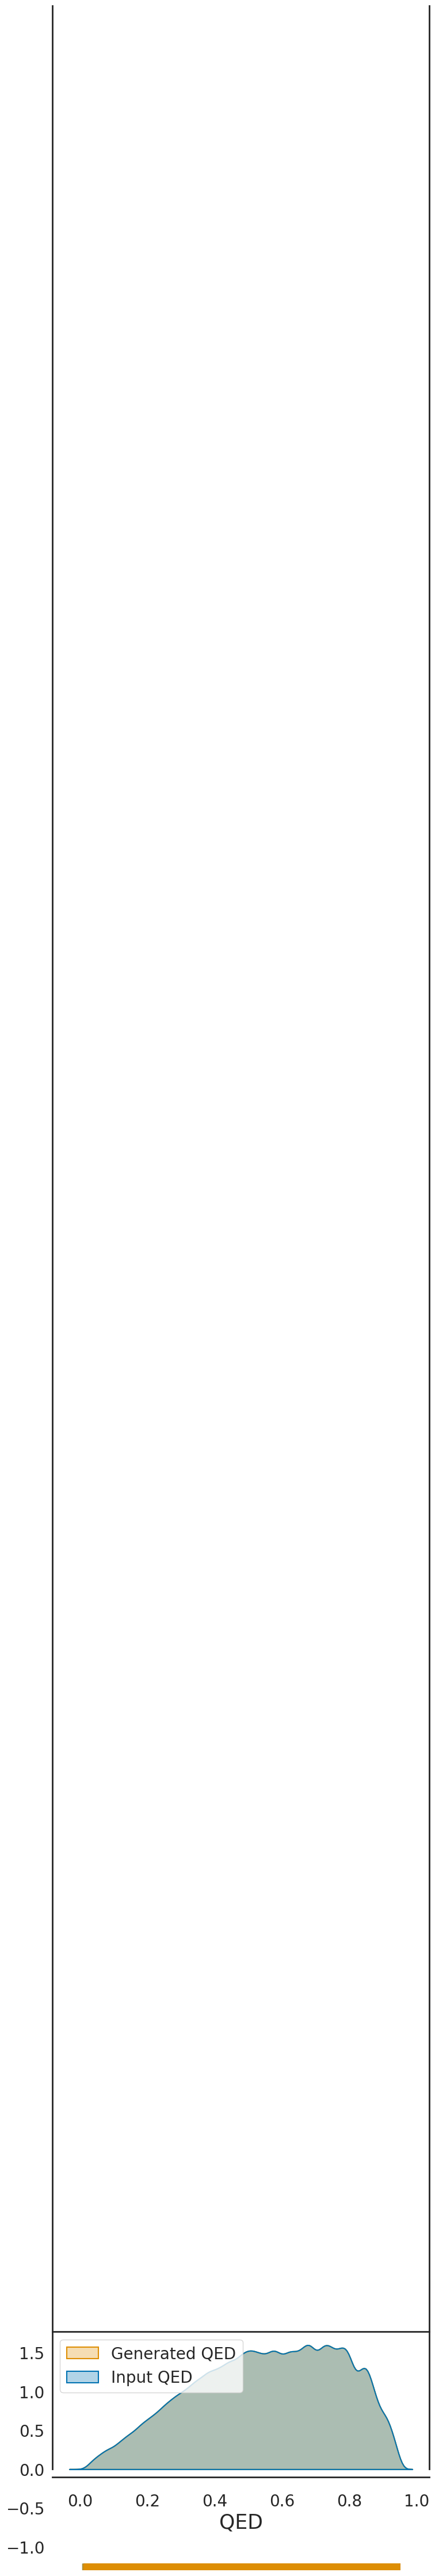

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
project_home = '/mnt/retmol/'

sns.set(style='white', font="Times New Roman")

values = res['original_qed'].tolist() + res['gen_qed'].tolist()
names = ['Input QED'] * len(res['original_qed']) + ['Generated QED'] * len(res['gen_qed'])

data = pd.DataFrame({
    'values': values,
    'names': names,
})

ax = sns.displot(
   data=data, x="values", hue="names",
   fill=True, common_norm=False, palette="colorblind",
   alpha=.3, linewidth=1.5, rug=True, kind='kde', facet_kws=dict(despine=False), height=5, aspect=1.5,
   rug_kws={"alpha": 0.7, "height":0.03}, legend = False
)

ax.set(ylim=(-1.3, None))
ax.ax.spines['bottom'].set_position(('data', -0.1))
ax.ax.spines['left'].set_bounds((0, 31.7))
ax.ax.spines['right'].set_bounds((0, 31.7))
for _,s in ax.ax.spines.items():
    s.set_linewidth(2)

ax.ax.tick_params(axis='x', labelsize= 20, pad=15)
ax.ax.tick_params(axis='y', labelsize= 20)
ax.ax.set_xlabel('QED', fontsize=25)
ax.ax.set_ylabel(None)

lgd = plt.legend(labels=['Generated QED', 'Input QED'], fontsize=20, loc='upper left')


count    1.273104e+06
mean     5.538576e-01
std      2.140206e-01
min      6.844353e-03
25%      3.935064e-01
50%      5.677359e-01
75%      7.300842e-01
max      9.483293e-01
Name: original_qed, dtype: float64

# Do joint learning

In [1]:
import os
import argparse
import json
import torch

import wandb
from tqdm import tqdm
from hybrid_transformer.configs.task import TaskConfig
from hybrid_transformer.configs.model import ModelConfig
from hybrid_transformer.configs.trainer import TrainerConfig
from hybrid_transformer.configs.logger import LoggerConfig

from hybrid_transformer.utils.datasets.auto import AutoDataset
from hybrid_transformer.utils.tokenizers.auto import AutoTokenizer
from hybrid_transformer.models.auto import AutoModel
from hybrid_transformer.utils.loggers.wandb import WandbLogger

from hybrid_transformer.trainers.trainer import Trainer

from scripts.joint_learning.train import DEFAULT_CONFIG_FILES

from hybrid_transformer.utils.objectives.guacamol.objective import GUACAMOL_TASKS
from hybrid_transformer.models.prediction import PREDICTION_MODEL_CONFIGS
from hybrid_transformer.utils.objectives.molecule_net.objective import MOLECULE_NET_TASKS, MOLECULE_NET_REGRESSION_TASKS, MOLECULE_NET_CLASSIFICATION_TASKS
from hybrid_transformer.utils.objectives.guacamol.objective import get_objective


%load_ext autoreload
%autoreload 2

# Auxiliary functions

def save_strings_to_file(strings, filename):
    with open(filename, 'w') as f:
        for s in strings:
            f.write(s + '\n')

def read_strings_from_file(filename):
    with open(filename, 'r') as f:
        strings = f.read().splitlines()
    return strings

def convert_strings_to_lists(strings):
    return [[s, f'MOL{i}'] for i, s in enumerate(strings)]

from scripts.pretrain.eval import DEFAULT_REFERENCE_FILE, evaluate_distribution_learning_guacamol


/home/adam/miniconda3/envs/hybrid-transformer/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-03 22:11:35.991047: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 22:11:35.992969: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 22:11:36.021436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 22:11:36.021454: E external/local_xla/xla/stream_executor/cu

In [2]:
%cd ..

/home/adam/Projects/hybrid-transformer


In [3]:
path_to_task_config = './configs/tasks/guacamol/qed_classification/config.json'
path_to_model_config = './configs/models/prediction/hybrid_transformer/config.json'

generated_samples = read_strings_from_file('smiles_generated_qed_classification_10000.txt')

task_config = TaskConfig.from_pretrained(path_to_task_config)
tokenizer = AutoTokenizer.from_config(task_config)
model_config = ModelConfig.from_pretrained(path_to_model_config)
trainer_config = TrainerConfig.from_pretrained('./configs/trainers/debug/')
trainer_config.compile = False
model_config.prediction_task = task_config.prediction_task
trainer_config.batch_size = 64
task_config.augmentation_prob = 0.0

model = AutoModel.from_config(model_config)
dataset = AutoDataset.from_config(task_config)
dataset.data = generated_samples
dataset.target = get_objective(smiles_list=generated_samples, objective='qed_classification')
trainer = Trainer(config=trainer_config, model=model, tokenizer=tokenizer, logger=None, eval_dataset=dataset)
trainer.load_checkpoint('./results/qed_classification/ckpt.pt')
trainer._train_init()
trainer.model.eval()

number of parameters: 38.06M
Validating Guacamol dataset...


10000it [00:01, 7367.80it/s]


Guacamol dataset loaded with 10000 valid examples!


100%|██████████| 8391/8391 [00:07<00:00, 1153.53it/s]


tokens per iteration will be: 16,384
Using cuda device
Successfully loaded checkpoint from ./results/qed_classification/ckpt.pt...
Random seed set to 1337
num decayed parameter tensors: 63, with 38,116,352 parameters
num non-decayed parameter tensors: 25, with 12,800 parameters
using fused AdamW: True


HybridTransformer(
  (transformer): ModuleDict(
    (wte): Embedding(588, 512)
    (wpe): Embedding(128, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x HybridTransformerBlock(
        (ln_1): LayerNorm()
        (attn_1): HybridSelfAttention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (kv_proj): Linear(in_features=512, out_features=1024, bias=False)
          (out_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (fc): Linear(in_features=512, out_features=2048, bias=False)
          (gelu): GELU(approximate='none')
          (proj): Linear(in_features=2048, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_feature

In [4]:
len(generated_samples)

8391

In [4]:
results = trainer.test(dataset)

Random seed set to 1337
num decayed parameter tensors: 63, with 38,116,352 parameters
num non-decayed parameter tensors: 25, with 12,800 parameters
using fused AdamW: True


In [5]:
results

{'acc': 0.95929203539823,
 'aucroc': 0.9561467889908257,
 'aucpr': 0.386632585754918,
 'y_pred': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
 

In [54]:
y_pred = results['y_pred']
y_true = results['y_true']

In [63]:
y_true_positive = [(y_t, y_p) for y_t, y_p in zip(y_true, y_pred) if y_t == 1.0]
y_true_positive

[(1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (1.0, 0.0)]

In [12]:
n = 10

samples = []
predictions = []
targets = []

with torch.no_grad():
    for i in range(0, len(dataset.data), n):
        samples_batch = dataset.data[i:i + n]
        targets_batch = dataset.target[i:i+n].flatten()
        mlm_probability = 0.0
        inputs = tokenizer._encode(samples_batch, targets_batch, 'mlm', device=trainer.device)
        outputs = model(
            task='mlm', input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'],
            labels=inputs['labels'], target=inputs['target'], eos_mask=inputs['eos_mask'])
        samples.extend(samples_batch)
        targets.extend(targets_batch)
        predictions.extend(outputs['prediction'].detach().cpu().flatten().numpy().tolist()) 

In [5]:
batch_size = 64

idx = [i for i in range(len(dataset))]
idx_batched = [idx[i: i + batch_size] for i in range(0, len(idx), batch_size)]

        
predictions = []
prediction_probs = []
targets = []

for batch in range(len(idx_batched)):
    idx = torch.Tensor(idx_batched[batch]).to(torch.long)
    inputs = trainer.tokenizer.get_inputs(
        dataset=dataset, task='mlm', batch_size=trainer.batch_size, device=trainer.device, idx=idx)
    with torch.no_grad():
        with trainer.ctx:
            outputs = trainer.model(
                task='mlm', input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'],
                labels=inputs['labels'], target=inputs['target'], eos_mask=inputs['eos_mask'])
    prediction = torch.argmax(outputs['prediction'], dim=1).detach().cpu()
    prediction_prob = outputs['prediction'][:, 1].detach().cpu()
    predictions.extend(dataset.undo_target_transform(prediction.cpu()))
    prediction_probs.extend(prediction_prob.cpu())
    targets.extend(dataset.undo_target_transform(inputs['target'].cpu()))


In [9]:
selected_samples = [target.item() for prediction, target in zip(predictions, targets) if prediction.item() == 1.0]

In [10]:
sum(selected_samples) / len(selected_samples)

0.5706214689265536

In [13]:
predictions

[tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 ten

In [23]:
len([predictions for prediction, target in zip(predictions, targets) if target == 1.0 and prediction >= 0.75])

6

In [25]:
len([predictions for prediction, target in zip(predictions, targets) if target == 0.0 and prediction >= 0.75])

232

In [42]:
threshold = 0.5
selected_samples = [(sample, target) for sample, target, prediction in zip(samples, targets, predictions) if prediction >= threshold]

In [43]:
selected_samples

[('c1(Cl)cc(SCc2noc(C3CCCN(C(=O)CN(C)C)C3)n2)ncc1', tensor(0)),
 ('c1ccc(CNc2ccccc2N2CCOCC2)cc1', tensor(0)),
 ('c1(Cl)ccc(Cl)c(N2CC3=NC4c5ccccc5C(=O)N4C(c4cccs4)C3(c3ccc(Cl)c(Cl)c3)C2)c1',
  tensor(0)),
 ('Nc1nc(-c2ccc(OC)cc2)c(Nc2ccc(OC)c(OC)c2)s1', tensor(0)),
 ('CC(=O)n1cc(C=CC(=O)O)c2cc3oc(=O)c(C(CO)CCO)cc3cc21', tensor(0)),
 ('C(=O)N1CCC=C(c2cc(CN(c3cccc(Oc4ccccc4)c3)C)on2)C1', tensor(0)),
 ('COc1oc(C2=CCCN(C)C2)nn1', tensor(0)),
 ('c1ccc(-c2nccn2Cc2ccccc2F)cc1NCc1c(CCOc2c(-c3c(C(C)C)cc(F)cc3)cccc2)noc1',
  tensor(0)),
 ('C1CC1c1nc2cccnc2n1CC(=O)N1CCS(C(c2cc(OC)c(OC)cc2)=O)CC1', tensor(0)),
 ('c1(NS(C)(=O)=O)ccc(C(=O)O)cc1NC(=O)c1cccc(C)c1C', tensor(0)),
 ('O=c1onc(-c2ccc(C)cc2)nc1SCC(O)=O', tensor(0)),
 ('C(COc1cc(C(C)(O)c2ccccc2Cl)ccc1)CC=CCCC(=O)O', tensor(0)),
 ('CN1CC(=O)N(c2ccccc2C)CC12CCN(Cc1cnn(C)c1)CC2', tensor(0)),
 ('O=C(O)C1CCC2(OC1)C1C(C)(C)CCCC1(C)C(N=O)CC2', tensor(0)),
 ('Cn1c(CC2(C)C(C)=CCCC2(C)C)cccc1=O', tensor(0)),
 ('C1(O)C2OP(=P(F)(=O)OC)(=O)OC1OC(C=O)C2O', 

In [39]:
correct_selected_samples = [sample for sample, objective in zip(selected_samples, selected_objective) if objective >= 0.9]

In [41]:
len(correct_selected_samples) / len(selected_samples)

0.014285714285714285

We generated 640 samples (10 sampling iters with batch size equal to 64). This took 30 minutes, hence generating one molecule takes 2.8 seconds. From 640 molecules, 22 have QED >=0.9, which is 1.8 \% of the data.  Hence, we can expect that upon sampling 10^4 molecules, we would sample 

In [37]:
data = chunks(dataset.data, 10)

In [38]:
for batch in data:
    print(batch)

['CCOC(=O)CCCn1nnnc1-c1ccc2c(c1)c(Cc1ccccc1)cn2Cc1ccccc1', 'O=C(Nc1cc(S(=O)(=O)N2CCCCC2)ccc1Cl)c1cc(=O)c2ccccc2o1', 'CCc1cc(Nc2ncc3c(n2)-c2c(nn(C)c2-c2ccc(F)cc2)CC3)n[nH]1', 'O=C(Nc1ccccc1C(=O)NN=Cc1c(O)ccc2ccccc12)c1cc(-c2ccccc2)nc2ccccc12', 'O=C1NC(=O)C2(CCOc3c(CC(F)(F)F)cccc32)N1', 'CCc1nn(Cc2ccc(CCC(=O)O)c(C)c2)c(=O)c2cccn12', 'Cc1onc(-c2ccc(F)cc2)c1CNc1ccc(C(=O)NCC2CCOC2)cn1', 'CC(=NN=C(N)S)C1=C(O)OC(c2ccccc2[N+](=O)[O-])(c2ccccc2)O1', 'O=C1c2cccnc2C(=Nc2ccccc2C(=O)O)c2ccccc21', 'CNC(=O)C1CCCCNC(=O)CCCCNC(=O)OCCCC(C(=O)NO)C(CC(C)C)C(=O)N1']
['S=C(S)NN1CCOCC1', 'CC(=NOCC(=O)OCC(=O)N1c2ccccc2Sc2ccccc21)c1ccccc1', 'Cc1csc(Sc2c(C=C3SC(=S)NC3=O)c(C)nc3c(C(F)(F)F)cccc23)n1', 'S=C(c1nnc[nH]1)N1CCc2ccccc21', 'Cc1cc(NC(=O)C=Cc2ccco2)no1', 'Oc1nc2cccc(Cl)c2c(O)c1-c1csc(-n2ccnc2)n1', 'CCON=Cc1ccc(OCC)c(N)c1', 'COc1cc(S)ccc1C(=O)OC(C)C(=O)N1CC(C)OC(C)C1', 'ON=C(NCc1cc(F)cc(F)c1)c1ccnc(Oc2cccc(Cl)c2)c1', 'CCCN1Cc2cccc(OC)c2OP1(=S)OCC']
['Cc1cccc(OCC=NNC(=O)c2ccncc2)c1', 'Cc1ccc(-c2nc(C(=O)NN(C

In [ ]:
def get_inputs(self, dataset, task, batch_size, device=None, idx=None):

    if idx is None:
        sampled_idx = torch.randperm(len(dataset))[:batch_size]
    else:
        sampled_idx = idx
    mlm_probability = self.mlm_probability

    if dataset.target_label is None:
        inputs = [dataset[idx] for idx in sampled_idx]
        target = None
    else:
        inputs = [dataset[idx][0] for idx in sampled_idx]
        target = torch.Tensor([dataset[idx][1] for idx in sampled_idx])
        

    
    mask = torch.einsum('bi, bj -> bij', (inputs['attention_mask'], inputs['attention_mask'])).unsqueeze(1)
    mask = mask if self.use_pad_token_attention_mask else None
    eos_mask = inputs['input_ids'] == self.eos_token_id

    if task == 'lm':
        mlm_probability = 0.0
        inputs, labels = self.prepare_tokens(
            self.set_generation_task_token(inputs['input_ids']), inputs['special_tokens_mask'], mlm_probability)
    elif task == 'mlm':
        inputs, labels = self.prepare_tokens(
            self.set_prediction_task_token(inputs['input_ids']), inputs['special_tokens_mask'], mlm_probability)
        # inputs = self.set_prediction_task_token(inputs)
    else:
        raise ValueError('Variable `task` must be either `lm` or `mlm`.')

    inputs = {'input_ids': inputs, 'attention_mask': mask, 'labels': labels, 'target': target, 'eos_mask': eos_mask}

    if device is not None:
        for key, value in inputs.items():
            if value is not None:
                inputs[key] = value.pin_memory().to(device, non_blocking=True)

    return inputs

In [ ]:
Load ZINC test between 0.7, 0.8

Sample 64

For Each generate 10 samples 

Look for how many it is ok 

In [14]:
# Load ZINC test
    
smiles = read_strings_from_file('/home/adam/Projects/hybrid-transformer/data/guacamol/test/smiles.txt')
qed = get_objective(smiles_list=smiles, objective='qed')

100%|██████████| 238706/238706 [03:28<00:00, 1143.79it/s]


In [15]:
smiles_high_qed = [smile for smile, value in zip(smiles, qed) if value >= 0.7 and value < 0.8]

In [19]:
import random

smiles_high_qed_sampled = random.sample(smiles_high_qed, 64)

In [21]:
smiles_high_qed_sampled

['COc1cc(C2CC(c3ccc(SC)cc3)=NN2)cc(OC)c1OC',
 'COc1ccc(-c2[nH]nc(C)c2-c2ccc(Cl)cc2)c(O)c1',
 'COc1ccc(Nc2ccnc(Nc3ccc(OC)cc3)n2)cc1',
 'Fc1ccc(CC2CCNCC2)cc1',
 'CC(C)(C)NC(=O)COc1coc(CN2CCN(Cc3ccccc3)CC2)cc1=O',
 'COc1ccnc(N2CCN(C(=O)COCC(F)(F)F)CC2)n1',
 'CCn1ncc2c1-c1c(C)sc(C)c1CCC2',
 'CCS(=O)(=O)CCC(=O)NNC(=O)N1Cc2ccccc2Oc2ccc(Cl)cc21',
 'CN(C)C(=O)c1cccc(-c2ccc(C3C(CO)N4CCCCN(C(=O)C5CCC5)CC34)cc2)c1',
 'CCCOC(=O)c1ccc(Cl)cc1NC(=O)c1ccccc1Cl',
 'Cc1ccc(-c2nc(CS(=O)(=O)CC(=O)NCCN3CCCC3)c(C)o2)cc1',
 'OC(CC1CCCCN1)C1CC(c2ccccc2)=Nc2c(Cl)cc(Cl)cc21',
 'O=C(O)c1ccccc1CSc1nc2ccccc2[nH]1',
 'C[n+]1ccccc1COc1ccc(C(C)(C)C)cc1',
 'CC(C)C(CO)NC(=O)c1ccc(NC(=O)N2Cc3ccccc3C2)cc1',
 'O=C1C2=C(CCCC2)C(=O)N1c1ccc(Cl)cc1F',
 'COc1ccc(CCn2ccnc2-c2cc3n(n2)CCCNC3)cc1',
 'NC(Cc1cccc(-c2cccc(CC(=O)O)c2)c1)C(=O)O',
 'CC(C)(C)c1cc(C(=O)N2CCS(=O)(=O)CC2)c(NC(=O)Nc2ccc(Cl)cc2)s1',
 'COc1cccc2cc(C(=O)Nc3ccccc3)c(=O)oc12',
 'Cc1ccc(C(=O)O)cc1N1CCC1=O',
 'COc1nc(Cl)nc(Nc2ccc(Cl)c(OCC=C(C)C)c2)n1',
 'COC(=O)N1C

In [13]:
smiles

['Cc1cc2c(c3oc(CCCC#N)cc13)C(=O)c1c(O)cccc1C2=O',
 'C=CCN1C(=O)C(=NNC(=S)NC2OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C2OC(C)=O)c2ccccc21',
 'O=C1C(=Cc2ccc(F)cc2)CCOc2c1ccc1ccccc21',
 'CC(C)CNc1cc(NCC(C)C)nc(NCC(C)C)n1',
 'CN1CCN(CCCOc2ccc(N3C(=O)C(=Cc4ccc(Oc5ccc([N+](=O)[O-])cc5)cc4)SC3=S)cc2)CC1',
 'COc1ccc2ccccc2c1C1CC1NC(C)=O',
 'Cc1ccc(-n2c(=O)[nH]cc(C(=O)Nc3ccc4c(c3)OCCO4)c2=O)cc1',
 'Cc1ccc(NCc2nnc(SCC(=O)NCCc3ccccc3)n2C)cc1',
 'CCCNC(=O)c1ccc2c(c1)N=C(C)c1c(C)ccc(C)c1S2',
 'COc1ccc(Cn2ccn(CC(=O)Nc3cc(C)ccc3C)c(=O)c2=O)cc1',
 'Cn1nccc1C(=O)NN=Cc1c(O)ccc2ccccc12',
 'CCOC(=O)Nc1cc(N)c2c(n1)NC(C)C(c1ccccc1)=N2',
 'Cn1nc(N)c2ncc(C(Cl)(Cl)Cl)nc21',
 'CC(C)CC(NC(=O)C(N)Cc1ccccc1)C(=O)NC(CC1CCCCC1)C(O)c1nccs1',
 'CON=C1C2CC(C)CC1C(c1cccc(Cl)c1)NC2c1cccc(Cl)c1',
 'Cn1cc(NC(=O)c2cc(NC(=O)c3ccc(C=Cc4cnc5ccccc5c4)cc3)cn2C)cc1C(=O)NCCNC(=N)N',
 'Nc1nc(-c2ccc(Cl)cc2)c(CC(=O)O)s1',
 'COc1cc(OC)c2c(=O)c3c([nH]c2c1)CCCC3',
 'O=C(OC1CC2CC1C1CCCCN1C2=O)N1CCC(c2ccccc2)CC1',
 'CCCCCCCCCCCCCCCCCCP(=O)(O)OC1CC

In [7]:
552 / 640

0.8625